**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

решение задачи бинарной классификации

----

In [1]:
import numpy as np
import numpy.random as rng
# import pandas as pd
# from tqdm import tqdm
# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

---

In [3]:
# # plt.plot( np.cosh(range(-10,10)))
# # plt.plot( np.tanh(range(-10,10)))
# # np.sech(range(-10,10))
# x = np.linspace(-.1,.1,1000)
# # plt.plot( x, (np.exp(x) + np.exp(-x) )/2. )
# plt.plot( x, np.cosh(x) )
# plt.grid()

---

In [4]:
import sys 
import logging

logging.basicConfig(
    format=u'[%(levelname)-8s] %(asctime)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
    stream=sys.stdout,
    )

# показывать выдачу всех строк ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## генерируем датасет

In [5]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X,target = make_blobs( n_samples=10_000, n_features=2, centers=2, cluster_std=[1.7,1.8] )
# X,target = make_blobs( n_samples=100_000, n_features=1024, centers=2, cluster_std=[1.7,1.8] )

# докидываем свободный член для линейных моделей
X = np.hstack([X,np.ones((X.shape[0],1))])

print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(10000, 3) (10000,)


In [6]:
logging.getLogger().setLevel(logging.CRITICAL) 
InteractiveShell.ast_node_interactivity = 'last_expr'

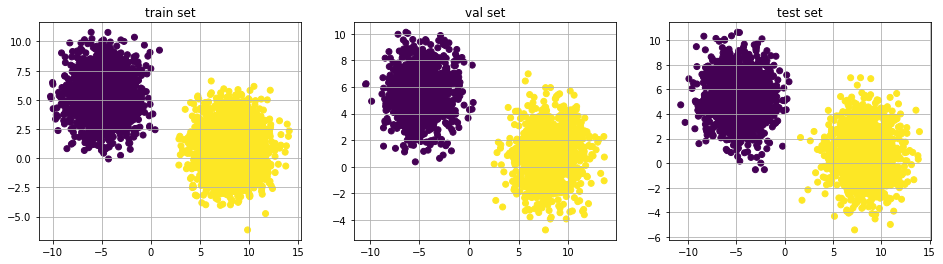

In [7]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],X_train[:,1],c=target_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],X_val[:,1],c=target_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],X_test[:,1],c=target_test)
ax2.set_title('test set')
ax2.grid()

In [8]:
logging.getLogger().setLevel(logging.DEBUG) 
InteractiveShell.ast_node_interactivity = 'all'

## MPL

In [9]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {-1,+1}
# y_train, y_val, y_test = [ (y*2)-1 for y in [ y_train, y_val, y_test ] ]

y_train.shape,y_val.shape,y_test.shape

((4489, 2), (2211, 2), (3300, 2))

In [10]:
class Activation:
    
    @staticmethod
    def transform(s): pass 
    
    @staticmethod
    def derivative(s): pass 
    
    

class BiSigmoid(Activation):
    
    @staticmethod
    def transform(s): return np.tanh(s) 
    
    @staticmethod
    def derivative(s): return 1./np.square(np.cosh(s))

    
    
class Sigmoid(Activation):
    
    @staticmethod
    def transform(s): 
        return 1./(1.+np.exp(-s) )
    
    @classmethod
    def derivative(cls,s): 
        o = cls.transform(s)
        return o*(1.-o)

    
    
class Softmax(Activation):
    
    @staticmethod
    def transform(s): 
        assert s.shape[1]>1,'incorrect activation argument size'
        es = np.exp(s)
        ess = es.sum(axis=1)[:,np.newaxis]
        with np.errstate(invalid='ignore',divide='ignore'):
            o = np.where( ess!=0., es/ess, 0. )
        return o
    
    @classmethod
    def derivative(cls,s): 
        o = cls.transform(s)
        return o*(1.-o) 
        
    

In [13]:
from lib.model.base import MLModel

class MLP(MLModel): 

    def __init__(self,initiator):
        self._activation = []
        super().__init__(initiator) # инициализируем параметры с помощью процедуры initiator

    def _reset(self): # процедура инициализации генерирует начальные веса модели
        self._weight = [ i[0].get() for i in self._initiator ]
        self._activation = [ i[1] for i in self._initiator ]
        return self    
        
    def _score(self,x): # генерируем выход модели
        o = x
        for i,w in enumerate(self._weight):
            o = self._activation[i].transform(o.dot(w))
        return o

    def _state(self,x):
        o,s = x, []
        for i,w in enumerate(self._weight):
            s.append( o.dot(w) )
            o = self._activation[i].transform(s[-1])
        return s
    
    def _score_derivative(self,x):
        o = [x]
        for i,w in enumerate(self._weight):
            o.append( self._activation[i].derivative(o[-1].dot(w)) )
        return o[1:]
    
    def _partial(self,x):
        return [ s*d for s,d in zip( self._state(x), self._score_derivative(x) ) ]


In [15]:
# from lib.model.mlp import MLP
from lib.initiator.linear import NormalInitiatorLinearModel

model = MLP(
    initiator=[
        [ NormalInitiatorLinearModel(input_size=X_train.shape[1], output_size=10,scale=.001,),BiSigmoid() ],
        [ NormalInitiatorLinearModel(input_size=10, output_size=y_train.shape[1],scale=.001,),BiSigmoid() ],
    ],)


# model.weight
# model._activation
# model.predict(X_test)
# [ s.shape for s in model._state(X_test) ] 
# [ d.shape for d in model._score_derivative(X_test) ]
[ p.shape for p in model._partial(X_test) ]

[(3300, 10), (3300, 2)]

In [ ]:
# s = np.array(model._state(X_test))

In [ ]:
# from lib.model.base import MLModel

# class MLP(MLModel): # однослойная нейросеть

#     def __init__(self,initiator):
#         super().__init__(initiator) # инициализируем параметры с помощью процедуры initiator

#     def _reset(self): # процедура инициализации генерирует начальные веса модели
#         self._weight = [ i.get() for i in self._initiator ]
#         return self    
        
#     def _score(self,x): # генерируем выход модели
#         o = x
#         for w in self._weight:
#             o = self._act(o.dot(w))
#         return o
    
#     @staticmethod
#     def _act(s): return np.tanh(s)
    
#     @staticmethod
#     def _act_derivative(s): 
#         return 1./np.square(np.cosh(s))

#     def _state(self,x):
#         o,s = x, []
#         for w in self._weight:
#             s.append( o.dot(w) )
#             o = self._act(s[-1])
#         return s
    
#     def _score_derivative(self,x):
#         o = [x]
#         for w in self._weight:
#             o.append( self._act_derivative(o[-1].dot(w)) )
#         return o[1:]
    
#     def _partial(self,x):
#         return [ s*d for s,d in zip( self._state(x), self._score_derivative(x) ) ]
    